<img width="200" style="float:left" 
     src="https://upload.wikimedia.org/wikipedia/commons/f/f3/Apache_Spark_logo.svg" />

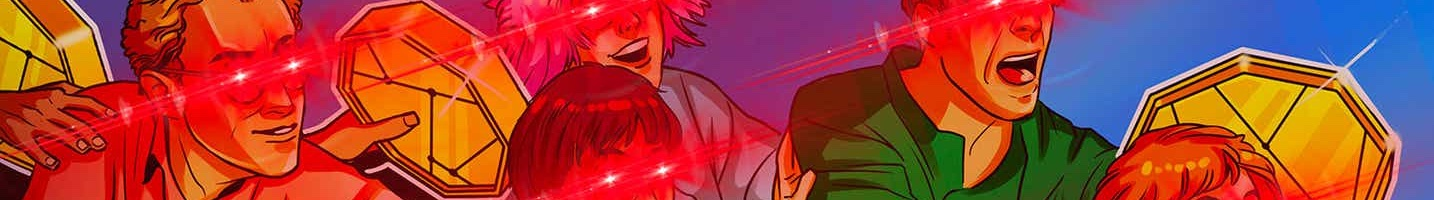

# Sections
* [Description](#0)
* [1. Setup](#1)
  * [1.1 Start Hadoop](#1.1)  
  * [1.2 Search for Spark Installation](#1.2)
  * [1.3 Create SparkSession](#1.3)
* [2. Lab](#2)
  * [2.1 Check Lab Files](#2.1)
  * [2.2 Create the DataFrames](#2.2)
  * [2.3 Create the GraphFrame](#2.3)
  * [2.4 Analytics](#2.4)
* [3. TearDown](#3)
  * [3.1 Stop Hadoop](#3.1)

<a id='0'></a>
## Description
<p>
<div>The goal for this lab is:</div>
<ul>    
    <li>Practice Spark GraphFrames API</li>
</ul>    
</p>

<p>We are going to work with a tweets dataset.</p>
<p>We are going to create a graph of cashtags/hashtags.</p>
<p>Each vertex will be a cashtag/hashtag and the edges will represent a shared appearance/occurrence between two in the same tweet.</p>
<p>Sometimes modeling a graph is not so obvious and creating the graph is the main problem.</p>

<a id='1'></a>
## 1. Setup

Since we are going to process data stored from HDFS let's start the service

<a id='1.1'></a>
### 1.1 Start Hadoop

Start Hadoop

Open a terminal and execute
```sh
hadoop-start.sh
```

<a id='1.2'></a>
### 1.2 Search for Spark Installation 
This step is required just because we are working in the course environment.

In [1]:
import findspark
findspark.init()

I'm changing pandas max column width property to improve data displaying

In [2]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

<a id='1.3'></a>
### 1.3 Create SparkSession

By setting this environment variable we can include extra libraries in our Spark cluster.<br/>
GraphFrames is not in spark core so we have to add it this way

In [3]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages "graphframes:graphframes:0.8.2-spark3.2-s_2.12" pyspark-shell'

The first thing always is to create the SparkSession

In [4]:
from pyspark.sql.session import SparkSession

spark = (SparkSession.builder
    .appName("Twitter - Analytics - GraphFrames")
    .config("spark.sql.warehouse.dir","hdfs://localhost:9000/warehouse")
    .enableHiveSupport()
    .getOrCreate())

:: loading settings :: url = jar:file:/opt/spark3/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/osbdet/.ivy2/cache
The jars for the packages stored in: /home/osbdet/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-dc59e582-ad88-48ff-a4c7-78bb96759702;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 154ms :: artifacts dl 5ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------

<a id='2'></a>
## 2. Lab

<a id='2.1'></a>
### 2.1 Check Lab Files

In order to complete this lab you need to previosly upload the datasets into HDFS.<br/>

Check you have the data ready in HDFS

http://localhost:50070/explorer.html#/datalake/std/twitter/bitcoin/


<a id='2.2'></a>
### 2.2 Create the DataFrames

The first step after creating the SparkSession is to create one or more DataFrames<br/>

In [5]:
tweets = spark.read.parquet("hdfs://localhost:9000/datalake/std/twitter/bitcoin/")

In [6]:
tweets.limit(2).toPandas()

,id,text,author_id,conversation_id,created_at,entities,geo,in_reply_to_user_id,lang,organic_metrics,possible_sensitive,promoted_metrics,public_metrics,referenced_tweets,reply_settings,source,withheld,year,dt
0,1576501000004726784,@freeglobetrekk @n3r4 LMAO!!,21822997,1576497392425504768,2022-10-02 09:15:03,"(None, None, None, [(None,), (None,)], None)","(None, None)",1361559785728925698,ht,None,None,None,"(0, 0, 0, 0)","[(replied_to, 1576500944489312256)]",everyone,Twitter for iPhone,None,2022,2022-10-02
1,1576501001900916737,@rovercrc too much BTC,1355410486922244096,1576256125191716864,2022-10-02 09:15:03,"(None, None, None, [(None,)], None)","(None, None)",1353384573435056128,en,None,None,None,"(0, 0, 0, 0)","[(replied_to, 1576256125191716864)]",everyone,Twitter Web App,None,2022,2022-10-02


In [7]:
tweets.select("entities").limit(2).printSchema()

root
 |-- entities: struct (nullable = true)
 |    |-- annotations: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- normalized_text: string (nullable = true)
 |    |    |    |-- type: string (nullable = true)
 |    |-- cashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- tag: string (nullable = true)
 |    |-- hashtags: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- tag: string (nullable = true)
 |    |-- mentions: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- tag: string (nullable = true)
 |    |-- urls: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- expanded_url: string (nullable = true)



I'm going to create a function that returns a new dataframe with the entities we need

In [8]:
from pyspark.sql.functions import *

def elements_by_tweets(df, entity):
    return (tweets.where(size(f"entities.{entity}.tag") > 1)
                 .select("id","text",col(f"entities.{entity}.tag").alias("elements")))


In [9]:
tweets.count()

4126

Let's find all the tweets with at least two **cashtags**

In [10]:
cashtags_by_tweet = elements_by_tweets(tweets,'cashtags')
cashtags_by_tweet.limit(5).toPandas()    

,id,text,elements
0,1576501001573773312,Thinking about doing a 10$ $ETH givaway if I'm at 100 followers just to celebrate that milestone with my early followers❤️ Is that okay? #blessed $sol $lunc $btc $xlm $xmr $link $bnb #btc #binance #bybit,"[ETH, sol, lunc, btc, xlm, xmr, link, bnb]"
1,1576501003658018816,"@DigiFinex $MILO will BIG PUMP soon🚀🚀🚀\n$CLOAK &amp; $MILO 💥💥💥\n$CLOAK Tax 3%, 2% burn $MILO &amp; 1% burn $CLOAK 🥰\n$MILO &amp; $CLOAK is the best 👍💯\n#MiloInu #MiloInuArmy #BSC #BNB #Binance #Crypto #BTC #BinanceSmartChain #Milo #Anime #Animation #Cartoon #CartoonFi","[MILO, CLOAK, MILO, CLOAK, MILO, CLOAK, MILO, CLOAK]"
2,1576501016026968065,"RT @nonfungiblesir: 💰 $500 IN $BTC GIVEAWAY 💰\n\nTo celebrate that @WhereAtOfficial moved to Discord, I’m giving away 2x $250 in $BTC! \n\nTo e…","[BTC, BTC]"
3,1576501060079915009,Version - 1.0\n\nAsset - UNIUSDTPERP\nSide - Long\nLevel - 1 [High Risk]\nPrice - 6.333\nTimeFrame - 15m\n\nCaution - This Data is delayed by 2 hours &amp; is for Backtesting purpose. Link in Bio.\n\n$BTC $VET $AXS $SHIB $ADA $GNO $QNT $LINK $KSM $KLAY $UNI #UNI,"[BTC, VET, AXS, SHIB, ADA, GNO, QNT, LINK, KSM, KLAY, UNI]"
4,1576501064420843520,"Most profitable crypto community sarver with Live alert quality update ,free LESSONS ,best analysis and free trial join here.🙏\nhttps://t.co/2WtPC24qun\n$LUNC $OGN $BTC $TSLA $COMP $SAND $GMT $SOL $U Y $XRP $GL $Y $TA $L $HATI $CAW $AMC $AAVE https://t.co/eRV975R6si","[LUNC, OGN, BTC, TSLA, COMP, SAND, GMT, SOL, U, XRP, GL, Y, TA, L, HATI, CAW, AMC, AAVE]"


Let's find all the tweets with at least two **hashtags**

In [11]:
hashtags_by_tweet = elements_by_tweets(tweets,'hashtags')
hashtags_by_tweet.limit(5).toPandas()   

,id,text,elements
0,1576501001573773312,Thinking about doing a 10$ $ETH givaway if I'm at 100 followers just to celebrate that milestone with my early followers❤️ Is that okay? #blessed $sol $lunc $btc $xlm $xmr $link $bnb #btc #binance #bybit,"[blessed, btc, binance, bybit]"
1,1576501003658018816,"@DigiFinex $MILO will BIG PUMP soon🚀🚀🚀\n$CLOAK &amp; $MILO 💥💥💥\n$CLOAK Tax 3%, 2% burn $MILO &amp; 1% burn $CLOAK 🥰\n$MILO &amp; $CLOAK is the best 👍💯\n#MiloInu #MiloInuArmy #BSC #BNB #Binance #Crypto #BTC #BinanceSmartChain #Milo #Anime #Animation #Cartoon #CartoonFi","[MiloInu, MiloInuArmy, BSC, BNB, Binance, Crypto, BTC, BinanceSmartChain, Milo, Anime, Animation, Cartoon, CartoonFi]"
2,1576501004555517952,@BTCTN Just a few hours left for our buy tax free event. \nCome in now and safe 10% tax on your purchase. \n\nMC 11k\n\nCan BOOM any time.\n\nBuy on Pancakeswap\nhttps://t.co/hGxpL06Tds\n\n#ATH #bscgems #bscgem #cryptocurrency #altcoin #QBEecosystem #cryptocurrency #Crypto #bitcoin #altcoins #nft,"[ATH, bscgems, bscgem, cryptocurrency, altcoin, QBEecosystem, cryptocurrency, Crypto, bitcoin, altcoins, nft]"
3,1576501006711590914,"Wrapped Bitcoin (WBTC)\nAnlık Fiyat: 19.267,40USDT\nGünlük Değişim: %-0,31\nAnlık Takip: https://t.co/27fKZibGNI\n#WBTC #KriptoCoin","[WBTC, KriptoCoin]"
4,1576501007273832453,"#ComputerSecurity #PenetrationTesting 渗透入侵获取信息一次40万人民币: 渗透入侵获取信息一次40万人民币 btc支付 走小飞机聊 先验证后付款 长期合作 保证一年赚1000万人民币左右 (Budget: $24000 - $40000 HKD, Jobs: Computer Security,… https://t.co/V9IFZVgSO8 Click Link to Apply","[ComputerSecurity, PenetrationTesting]"


Some tweets have repeated entities and some of them are mixing lower and upper case. Let's fix it

In [12]:
@udf("array<string>")
def upper_case(a):
    if not a:
        return a    
    return list(map(lambda x: x.upper(), a))

In [13]:
cashtags_by_tweets_fixed = cashtags_by_tweet.withColumn("cashtags",array_sort(array_distinct(upper_case("elements"))))
cashtags_by_tweets_fixed.limit(5).toPandas()

,id,text,elements,cashtags
0,1576501001573773312,Thinking about doing a 10$ $ETH givaway if I'm at 100 followers just to celebrate that milestone with my early followers❤️ Is that okay? #blessed $sol $lunc $btc $xlm $xmr $link $bnb #btc #binance #bybit,"[ETH, sol, lunc, btc, xlm, xmr, link, bnb]","[BNB, BTC, ETH, LINK, LUNC, SOL, XLM, XMR]"
1,1576501003658018816,"@DigiFinex $MILO will BIG PUMP soon🚀🚀🚀\n$CLOAK &amp; $MILO 💥💥💥\n$CLOAK Tax 3%, 2% burn $MILO &amp; 1% burn $CLOAK 🥰\n$MILO &amp; $CLOAK is the best 👍💯\n#MiloInu #MiloInuArmy #BSC #BNB #Binance #Crypto #BTC #BinanceSmartChain #Milo #Anime #Animation #Cartoon #CartoonFi","[MILO, CLOAK, MILO, CLOAK, MILO, CLOAK, MILO, CLOAK]","[CLOAK, MILO]"
2,1576501016026968065,"RT @nonfungiblesir: 💰 $500 IN $BTC GIVEAWAY 💰\n\nTo celebrate that @WhereAtOfficial moved to Discord, I’m giving away 2x $250 in $BTC! \n\nTo e…","[BTC, BTC]",[BTC]
3,1576501060079915009,Version - 1.0\n\nAsset - UNIUSDTPERP\nSide - Long\nLevel - 1 [High Risk]\nPrice - 6.333\nTimeFrame - 15m\n\nCaution - This Data is delayed by 2 hours &amp; is for Backtesting purpose. Link in Bio.\n\n$BTC $VET $AXS $SHIB $ADA $GNO $QNT $LINK $KSM $KLAY $UNI #UNI,"[BTC, VET, AXS, SHIB, ADA, GNO, QNT, LINK, KSM, KLAY, UNI]","[ADA, AXS, BTC, GNO, KLAY, KSM, LINK, QNT, SHIB, UNI, VET]"
4,1576501064420843520,"Most profitable crypto community sarver with Live alert quality update ,free LESSONS ,best analysis and free trial join here.🙏\nhttps://t.co/2WtPC24qun\n$LUNC $OGN $BTC $TSLA $COMP $SAND $GMT $SOL $U Y $XRP $GL $Y $TA $L $HATI $CAW $AMC $AAVE https://t.co/eRV975R6si","[LUNC, OGN, BTC, TSLA, COMP, SAND, GMT, SOL, U, XRP, GL, Y, TA, L, HATI, CAW, AMC, AAVE]","[AAVE, AMC, BTC, CAW, COMP, GL, GMT, HATI, L, LUNC, OGN, SAND, SOL, TA, TSLA, U, XRP, Y]"


In [14]:
hashtags_by_tweets_fixed = hashtags_by_tweet.withColumn("hashtags",array_sort(array_distinct(upper_case("elements"))))
hashtags_by_tweets_fixed.limit(5).toPandas()

,id,text,elements,hashtags
0,1576501001573773312,Thinking about doing a 10$ $ETH givaway if I'm at 100 followers just to celebrate that milestone with my early followers❤️ Is that okay? #blessed $sol $lunc $btc $xlm $xmr $link $bnb #btc #binance #bybit,"[blessed, btc, binance, bybit]","[BINANCE, BLESSED, BTC, BYBIT]"
1,1576501003658018816,"@DigiFinex $MILO will BIG PUMP soon🚀🚀🚀\n$CLOAK &amp; $MILO 💥💥💥\n$CLOAK Tax 3%, 2% burn $MILO &amp; 1% burn $CLOAK 🥰\n$MILO &amp; $CLOAK is the best 👍💯\n#MiloInu #MiloInuArmy #BSC #BNB #Binance #Crypto #BTC #BinanceSmartChain #Milo #Anime #Animation #Cartoon #CartoonFi","[MiloInu, MiloInuArmy, BSC, BNB, Binance, Crypto, BTC, BinanceSmartChain, Milo, Anime, Animation, Cartoon, CartoonFi]","[ANIMATION, ANIME, BINANCE, BINANCESMARTCHAIN, BNB, BSC, BTC, CARTOON, CARTOONFI, CRYPTO, MILO, MILOINU, MILOINUARMY]"
2,1576501004555517952,@BTCTN Just a few hours left for our buy tax free event. \nCome in now and safe 10% tax on your purchase. \n\nMC 11k\n\nCan BOOM any time.\n\nBuy on Pancakeswap\nhttps://t.co/hGxpL06Tds\n\n#ATH #bscgems #bscgem #cryptocurrency #altcoin #QBEecosystem #cryptocurrency #Crypto #bitcoin #altcoins #nft,"[ATH, bscgems, bscgem, cryptocurrency, altcoin, QBEecosystem, cryptocurrency, Crypto, bitcoin, altcoins, nft]","[ALTCOIN, ALTCOINS, ATH, BITCOIN, BSCGEM, BSCGEMS, CRYPTO, CRYPTOCURRENCY, NFT, QBEECOSYSTEM]"
3,1576501006711590914,"Wrapped Bitcoin (WBTC)\nAnlık Fiyat: 19.267,40USDT\nGünlük Değişim: %-0,31\nAnlık Takip: https://t.co/27fKZibGNI\n#WBTC #KriptoCoin","[WBTC, KriptoCoin]","[KRIPTOCOIN, WBTC]"
4,1576501007273832453,"#ComputerSecurity #PenetrationTesting 渗透入侵获取信息一次40万人民币: 渗透入侵获取信息一次40万人民币 btc支付 走小飞机聊 先验证后付款 长期合作 保证一年赚1000万人民币左右 (Budget: $24000 - $40000 HKD, Jobs: Computer Security,… https://t.co/V9IFZVgSO8 Click Link to Apply","[ComputerSecurity, PenetrationTesting]","[COMPUTERSECURITY, PENETRATIONTESTING]"


Let's create all possible elements permutations

In [15]:
from itertools import permutations

@udf("array<array<string>>")
def combine(a):
    return list(permutations(a, 2))
 

In [16]:
cashtag_pair_by_tweet = cashtags_by_tweets_fixed.select("id",combine("cashtags").alias("permutations"))
cashtag_pair_by_tweet.limit(5).toPandas()

,id,permutations
0,1576501001573773312,"[[BNB, BTC], [BNB, ETH], [BNB, LINK], [BNB, LUNC], [BNB, SOL], [BNB, XLM], [BNB, XMR], [BTC, BNB], [BTC, ETH], [BTC, LINK], [BTC, LUNC], [BTC, SOL], [BTC, XLM], [BTC, XMR], [ETH, BNB], [ETH, BTC], [ETH, LINK], [ETH, LUNC], [ETH, SOL], [ETH, XLM], [ETH, XMR], [LINK, BNB], [LINK, BTC], [LINK, ETH], [LINK, LUNC], [LINK, SOL], [LINK, XLM], [LINK, XMR], [LUNC, BNB], [LUNC, BTC], [LUNC, ETH], [LUNC, LINK], [LUNC, SOL], [LUNC, XLM], [LUNC, XMR], [SOL, BNB], [SOL, BTC], [SOL, ETH], [SOL, LINK], [SOL, LUNC], [SOL, XLM], [SOL, XMR], [XLM, BNB], [XLM, BTC], [XLM, ETH], [XLM, LINK], [XLM, LUNC], [XLM, SOL], [XLM, XMR], [XMR, BNB], [XMR, BTC], [XMR, ETH], [XMR, LINK], [XMR, LUNC], [XMR, SOL], [XMR, XLM]]"
1,1576501003658018816,"[[CLOAK, MILO], [MILO, CLOAK]]"
2,1576501016026968065,[]
3,1576501060079915009,"[[ADA, AXS], [ADA, BTC], [ADA, GNO], [ADA, KLAY], [ADA, KSM], [ADA, LINK], [ADA, QNT], [ADA, SHIB], [ADA, UNI], [ADA, VET], [AXS, ADA], [AXS, BTC], [AXS, GNO], [AXS, KLAY], [AXS, KSM], [AXS, LINK], [AXS, QNT], [AXS, SHIB], [AXS, UNI], [AXS, VET], [BTC, ADA], [BTC, AXS], [BTC, GNO], [BTC, KLAY], [BTC, KSM], [BTC, LINK], [BTC, QNT], [BTC, SHIB], [BTC, UNI], [BTC, VET], [GNO, ADA], [GNO, AXS], [GNO, BTC], [GNO, KLAY], [GNO, KSM], [GNO, LINK], [GNO, QNT], [GNO, SHIB], [GNO, UNI], [GNO, VET], [KLAY, ADA], [KLAY, AXS], [KLAY, BTC], [KLAY, GNO], [KLAY, KSM], [KLAY, LINK], [KLAY, QNT], [KLAY, SHIB], [KLAY, UNI], [KLAY, VET], [KSM, ADA], [KSM, AXS], [KSM, BTC], [KSM, GNO], [KSM, KLAY], [KSM, LINK], [KSM, QNT], [KSM, SHIB], [KSM, UNI], [KSM, VET], [LINK, ADA], [LINK, AXS], [LINK, BTC], [LINK, GNO], [LINK, KLAY], [LINK, KSM], [LINK, QNT], [LINK, SHIB], [LINK, UNI], [LINK, VET], [QNT, ADA], [QNT, AXS], [QNT, BTC], [QNT, GNO], [QNT, KLAY], [QNT, KSM], [QNT, LINK], [QNT, SHIB], [QNT, UNI], [QNT, VET], [SHIB, ADA], [SHIB, AXS], [SHIB, BTC], [SHIB, GNO], [SHIB, KLAY], [SHIB, KSM], [SHIB, LINK], [SHIB, QNT], [SHIB, UNI], [SHIB, VET], [UNI, ADA], [UNI, AXS], [UNI, BTC], [UNI, GNO], [UNI, KLAY], [UNI, KSM], [UNI, LINK], [UNI, QNT], [UNI, SHIB], [UNI, VET], ...]"
4,1576501064420843520,"[[AAVE, AMC], [AAVE, BTC], [AAVE, CAW], [AAVE, COMP], [AAVE, GL], [AAVE, GMT], [AAVE, HATI], [AAVE, L], [AAVE, LUNC], [AAVE, OGN], [AAVE, SAND], [AAVE, SOL], [AAVE, TA], [AAVE, TSLA], [AAVE, U], [AAVE, XRP], [AAVE, Y], [AMC, AAVE], [AMC, BTC], [AMC, CAW], [AMC, COMP], [AMC, GL], [AMC, GMT], [AMC, HATI], [AMC, L], [AMC, LUNC], [AMC, OGN], [AMC, SAND], [AMC, SOL], [AMC, TA], [AMC, TSLA], [AMC, U], [AMC, XRP], [AMC, Y], [BTC, AAVE], [BTC, AMC], [BTC, CAW], [BTC, COMP], [BTC, GL], [BTC, GMT], [BTC, HATI], [BTC, L], [BTC, LUNC], [BTC, OGN], [BTC, SAND], [BTC, SOL], [BTC, TA], [BTC, TSLA], [BTC, U], [BTC, XRP], [BTC, Y], [CAW, AAVE], [CAW, AMC], [CAW, BTC], [CAW, COMP], [CAW, GL], [CAW, GMT], [CAW, HATI], [CAW, L], [CAW, LUNC], [CAW, OGN], [CAW, SAND], [CAW, SOL], [CAW, TA], [CAW, TSLA], [CAW, U], [CAW, XRP], [CAW, Y], [COMP, AAVE], [COMP, AMC], [COMP, BTC], [COMP, CAW], [COMP, GL], [COMP, GMT], [COMP, HATI], [COMP, L], [COMP, LUNC], [COMP, OGN], [COMP, SAND], [COMP, SOL], [COMP, TA], [COMP, TSLA], [COMP, U], [COMP, XRP], [COMP, Y], [GL, AAVE], [GL, AMC], [GL, BTC], [GL, CAW], [GL, COMP], [GL, GMT], [GL, HATI], [GL, L], [GL, LUNC], [GL, OGN], [GL, SAND], [GL, SOL], [GL, TA], [GL, TSLA], [GL, U], ...]"


In [17]:
hashtag_pair_by_tweet = hashtags_by_tweets_fixed.select("id",combine("hashtags").alias("permutations"))
hashtag_pair_by_tweet.limit(5).toPandas()

,id,permutations
0,1576501001573773312,"[[BINANCE, BLESSED], [BINANCE, BTC], [BINANCE, BYBIT], [BLESSED, BINANCE], [BLESSED, BTC], [BLESSED, BYBIT], [BTC, BINANCE], [BTC, BLESSED], [BTC, BYBIT], [BYBIT, BINANCE], [BYBIT, BLESSED], [BYBIT, BTC]]"
1,1576501003658018816,"[[ANIMATION, ANIME], [ANIMATION, BINANCE], [ANIMATION, BINANCESMARTCHAIN], [ANIMATION, BNB], [ANIMATION, BSC], [ANIMATION, BTC], [ANIMATION, CARTOON], [ANIMATION, CARTOONFI], [ANIMATION, CRYPTO], [ANIMATION, MILO], [ANIMATION, MILOINU], [ANIMATION, MILOINUARMY], [ANIME, ANIMATION], [ANIME, BINANCE], [ANIME, BINANCESMARTCHAIN], [ANIME, BNB], [ANIME, BSC], [ANIME, BTC], [ANIME, CARTOON], [ANIME, CARTOONFI], [ANIME, CRYPTO], [ANIME, MILO], [ANIME, MILOINU], [ANIME, MILOINUARMY], [BINANCE, ANIMATION], [BINANCE, ANIME], [BINANCE, BINANCESMARTCHAIN], [BINANCE, BNB], [BINANCE, BSC], [BINANCE, BTC], [BINANCE, CARTOON], [BINANCE, CARTOONFI], [BINANCE, CRYPTO], [BINANCE, MILO], [BINANCE, MILOINU], [BINANCE, MILOINUARMY], [BINANCESMARTCHAIN, ANIMATION], [BINANCESMARTCHAIN, ANIME], [BINANCESMARTCHAIN, BINANCE], [BINANCESMARTCHAIN, BNB], [BINANCESMARTCHAIN, BSC], [BINANCESMARTCHAIN, BTC], [BINANCESMARTCHAIN, CARTOON], [BINANCESMARTCHAIN, CARTOONFI], [BINANCESMARTCHAIN, CRYPTO], [BINANCESMARTCHAIN, MILO], [BINANCESMARTCHAIN, MILOINU], [BINANCESMARTCHAIN, MILOINUARMY], [BNB, ANIMATION], [BNB, ANIME], [BNB, BINANCE], [BNB, BINANCESMARTCHAIN], [BNB, BSC], [BNB, BTC], [BNB, CARTOON], [BNB, CARTOONFI], [BNB, CRYPTO], [BNB, MILO], [BNB, MILOINU], [BNB, MILOINUARMY], [BSC, ANIMATION], [BSC, ANIME], [BSC, BINANCE], [BSC, BINANCESMARTCHAIN], [BSC, BNB], [BSC, BTC], [BSC, CARTOON], [BSC, CARTOONFI], [BSC, CRYPTO], [BSC, MILO], [BSC, MILOINU], [BSC, MILOINUARMY], [BTC, ANIMATION], [BTC, ANIME], [BTC, BINANCE], [BTC, BINANCESMARTCHAIN], [BTC, BNB], [BTC, BSC], [BTC, CARTOON], [BTC, CARTOONFI], [BTC, CRYPTO], [BTC, MILO], [BTC, MILOINU], [BTC, MILOINUARMY], [CARTOON, ANIMATION], [CARTOON, ANIME], [CARTOON, BINANCE], [CARTOON, BINANCESMARTCHAIN], [CARTOON, BNB], [CARTOON, BSC], [CARTOON, BTC], [CARTOON, CARTOONFI], [CARTOON, CRYPTO], [CARTOON, MILO], [CARTOON, MILOINU], [CARTOON, MILOINUARMY], [CARTOONFI, ANIMATION], [CARTOONFI, ANIME], [CARTOONFI, BINANCE], [CARTOONFI, BINANCESMARTCHAIN], ...]"
2,1576501004555517952,"[[ALTCOIN, ALTCOINS], [ALTCOIN, ATH], [ALTCOIN, BITCOIN], [ALTCOIN, BSCGEM], [ALTCOIN, BSCGEMS], [ALTCOIN, CRYPTO], [ALTCOIN, CRYPTOCURRENCY], [ALTCOIN, NFT], [ALTCOIN, QBEECOSYSTEM], [ALTCOINS, ALTCOIN], [ALTCOINS, ATH], [ALTCOINS, BITCOIN], [ALTCOINS, BSCGEM], [ALTCOINS, BSCGEMS], [ALTCOINS, CRYPTO], [ALTCOINS, CRYPTOCURRENCY], [ALTCOINS, NFT], [ALTCOINS, QBEECOSYSTEM], [ATH, ALTCOIN], [ATH, ALTCOINS], [ATH, BITCOIN], [ATH, BSCGEM], [ATH, BSCGEMS], [ATH, CRYPTO], [ATH, CRYPTOCURRENCY], [ATH, NFT], [ATH, QBEECOSYSTEM], [BITCOIN, ALTCOIN], [BITCOIN, ALTCOINS], [BITCOIN, ATH], [BITCOIN, BSCGEM], [BITCOIN, BSCGEMS], [BITCOIN, CRYPTO], [BITCOIN, CRYPTOCURRENCY], [BITCOIN, NFT], [BITCOIN, QBEECOSYSTEM], [BSCGEM, ALTCOIN], [BSCGEM, ALTCOINS], [BSCGEM, ATH], [BSCGEM, BITCOIN], [BSCGEM, BSCGEMS], [BSCGEM, CRYPTO], [BSCGEM, CRYPTOCURRENCY], [BSCGEM, NFT], [BSCGEM, QBEECOSYSTEM], [BSCGEMS, ALTCOIN], [BSCGEMS, ALTCOINS], [BSCGEMS, ATH], [BSCGEMS, BITCOIN], [BSCGEMS, BSCGEM], [BSCGEMS, CRYPTO], [BSCGEMS, CRYPTOCURRENCY], [BSCGEMS, NFT], [BSCGEMS, QBEECOSYSTEM], [CRYPTO, ALTCOIN], [CRYPTO, ALTCOINS], [CRYPTO, ATH], [CRYPTO, BITCOIN], [CRYPTO, BSCGEM], [CRYPTO, BSCGEMS], [CRYPTO, CRYPTOCURRENCY], [CRYPTO, NFT], [CRYPTO, QBEECOSYSTEM], [CRYPTOCURRENCY, ALTCOIN], [CRYPTOCURRENCY, ALTCOINS], [CRYPTOCURRENCY, ATH], [CRYPTOCURRENCY, BITCOIN], [CRYPTOCURRENCY, BSCGEM], [CRYPTOCURRENCY, BSCGEMS], [CRYPTOCURRENCY, CRYPTO], [CRYPTOCURRENCY, NFT], [CRYPTOCURRENCY, QBEECOSYSTEM], [NFT, ALTCOIN], [NFT, ALTCOINS], [NFT, ATH], [NFT, BITCOIN], [NFT, BSCGEM], [NFT, BSCGEMS], [NFT, CRYPTO], [NFT, CRYPTOCURRENCY], [NFT, QBEECOSYSTEM], [QBEECOSYSTEM, ALTCOIN], [QBEECOSYSTEM, ALTCOINS], [QBEECOSYSTEM, ATH], [

Let's explode the combinations

In [18]:
cashtags = (cashtag_pair_by_tweet
                     .select(explode("permutations").alias("pair"))
                     .select(col("pair")[0].alias("cashtag1"),
                             col("pair")[1].alias("cashtag2")))
                                                       
cashtags.limit(5).toPandas()

,cashtag1,cashtag2
0,BNB,BTC
1,BNB,ETH
2,BNB,LINK
3,BNB,LUNC
4,BNB,SOL


In [19]:
hashtags = (hashtag_pair_by_tweet
                     .select(explode("permutations").alias("pair"))
                     .select(col("pair")[0].alias("hashtag1"),
                             col("pair")[1].alias("hashtag2")))
                                                       
hashtags.limit(5).toPandas()

,hashtag1,hashtag2
0,BINANCE,BLESSED
1,BINANCE,BTC
2,BINANCE,BYBIT
3,BLESSED,BINANCE
4,BLESSED,BTC


Let's create a the cashtags & hashtags dataframes

In [20]:
c_vertices = (cashtags.select("cashtag1").union(cashtags.select("cashtag2"))
           .distinct()           
           .withColumnRenamed("cashtag1","id"))
        
c_edges = (cashtags
            .withColumnRenamed("cashtag1","src")
            .withColumnRenamed("cashtag2","dst")
            .groupBy("src","dst")
            .agg(
                count("*").alias("occurrences")
            ))

h_vertices = (hashtags.select("hashtag1").union(hashtags.select("hashtag2"))
           .distinct()           
           .withColumnRenamed("hashtag1","id"))
        
h_edges = (hashtags
            .withColumnRenamed("hashtag1","src")
            .withColumnRenamed("hashtag2","dst")
            .groupBy("src","dst")
            .agg(
                count("*").alias("occurrences")
            ))


In [21]:
c_vertices.count()

165

In [22]:
c_vertices.limit(5).toPandas()

,id
0,CRAMER
1,NBS
2,MATIC
3,SL
4,QTUM


In [23]:
c_edges.count()

2870

In [24]:
c_edges.limit(5).toPandas()

,src,dst,occurrences
0,AAVE,SAND,2
1,TSLA,TA,2
2,GALA,BNB,1
3,LUNA,GALA,1
4,UNO,GMPD,1


In [25]:
h_vertices.count()

937

In [26]:
h_vertices.limit(5).toPandas()

,id
0,CBDC
1,MARKETPEAK
2,SAFEMOON
3,HEL
4,GEMINI


In [27]:
h_edges.count()

12648

In [28]:
h_edges.limit(5).toPandas()

,src,dst,occurrences
0,BSCGEM,NFT,37
1,WEB3,BITCOIN,82
2,CELRUSDT,CELR,1
3,BTC,PITBULL,1
4,BTC,UKRAINEWAR,1


<a id='2.3'></a>
### 2.3 Create the GraphFrame

We are going to model our graph in the following way:<br/>
**vertices** : cashtags/hashtags <br/>
**edges** : cashtags/hashtags pairs aggregation

In [29]:
from graphframes import GraphFrame

cashtag_graph = GraphFrame(c_vertices, c_edges)
cashtag_graph.cache()

hashtag_graph = GraphFrame(h_vertices, h_edges)
hashtag_graph.cache()


GraphFrame(v:[id: string], e:[src: string, dst: string ... 1 more field])

<a id='2.4'></a>
### 2.4 Analytics

#### which are the top 10 most common cashtags pairs?

In [30]:
cashtag_graph.edges.orderBy(desc("occurrences")).limit(10).toPandas()

,src,dst,occurrences
0,ETH,BTC,29
1,BTC,ETH,29
2,DOGE,ETH,17
3,BTC,DOGE,17
4,DOGE,BTC,17
5,ETH,DOGE,17
6,BTC,SOL,15
7,SOL,BTC,15
8,ETH,SOL,14
9,SOL,ETH,14


#### which are the top 10 cashtags with more triangles?

In [31]:
cashtag_graph.triangleCount().orderBy(desc("count")).limit(10).toPandas()

,count,id
0,1070,ETH
1,1066,BTC
2,755,SOL
3,738,MATIC
4,624,LUNC
5,591,ATOM
6,589,XRP
7,587,LUNA
8,491,ETC
9,463,BNB


#### how many communities/clusters there are?

In [32]:
(cashtag_graph.stronglyConnectedComponents(maxIter=10)
     .sort("component")
     .groupby("component")
     .agg(collect_list("id").alias("cryptocurrencies"))).toPandas()
     

,component,cryptocurrencies
0,25769803776,"[LUNC, RUNE, SRM, CRAMER, SLP, FTM, NBS, WCI, MATIC, GNO, QTUM, THETA, DAL, SL, TRB, PVU, OGN, QUACK, AMC, XMC, VOLT, VALID, VIDT, CATE, COMP, USDC, EOS, MITH, JASMY, KNC, CPC, OP, CULT, LUNA, IOTA, DOT, MUSE, XMR, RSR, AKA, TVK, MKR, DC, APA, ET, FIB, MOVR, PAXG, GL, SPY, LTC, S, CHZ, ATOM, ETH, AVAX, TFUEL, XPR, SPX, ZOON, ICP, ARV, MANA, IMX, CRV, GMPD, SUN, MBOX, APE, QNT, KLAY, AEO, BTC, TWT, KEY, TIDAL, SYS, TSLA, XLM, GIGA, HATI, INSTAR, VET, PRO, AXS, CRO, ERN, WOO, EHIVE, CSC, DOGE, SKIL, USTD, EGLD, NEXO, KSM, DFI, MARVIN, GMT, ATH, ...]"
1,283467841536,"[MILO, CLOAK]"
2,773094113282,"[OBX, RUX]"
3,979252543490,"[XDC, XSP]"
4,1288490188800,"[DARTH, DWARF, JEDI]"


#### which are the most relevant cashtags?
We are going to apply the Page Ranks algorithm

In [33]:
cashtag_rank = cashtag_graph.pageRank(resetProbability=0.15, maxIter=10)

The algorithm returns a GraphFrame

In [34]:
cashtag_rank.vertices.orderBy(desc("pagerank")).limit(5).toPandas()

,id,pagerank
0,BTC,6.887850
1,ETH,4.777425
2,MATIC,3.456270
3,SOL,3.115566
4,USDT,2.848902


In [35]:
cashtag_rank.edges.limit(5).toPandas()

,src,dst,occurrences,weight
0,CRAMER,LUNC,1,0.076923
1,CRAMER,EHIVE,1,0.076923
2,CRAMER,VALID,1,0.076923
3,CRAMER,CULT,1,0.076923
4,CRAMER,WCI,1,0.076923


#### which are the top 10 most common hashtags pairs?

In [36]:
hashtag_graph.edges.orderBy(desc("occurrences")).limit(10).toPandas()

,src,dst,occurrences
0,NFT,BITCOIN,150
1,BITCOIN,NFT,150
2,CRYPTO,BITCOIN,143
3,BITCOIN,CRYPTO,143
4,BITCOIN,CRYPTOCURRENCY,130
5,CRYPTOCURRENCY,BITCOIN,130
6,CRYPTOCURRENCY,CRYPTO,128
7,CRYPTO,CRYPTOCURRENCY,128
8,ETH,WEB3,117
9,WEB3,ETH,117


#### which are the most relevant hashtags?
We are going to apply the Page Ranks algorithm

In [37]:
hashtag_rank = hashtag_graph.pageRank(resetProbability=0.15, maxIter=10)

In [38]:
hashtag_rank.vertices.orderBy(desc("pagerank")).limit(5).toPandas()

,id,pagerank
0,BTC,32.433615
1,BITCOIN,28.878179
2,ETH,18.435317
3,CRYPTO,17.638273
4,BNB,13.666520


In [39]:
hashtag_rank.edges.limit(5).toPandas()

,src,dst,occurrences,weight
0,BITCOIN,CBDC,1,0.002457
1,NFTDROP,MARKETPEAK,1,0.058824
2,OPENSEANFTS,MARKETPEAK,1,0.083333
3,DIGITALASSET,MARKETPEAK,1,0.032258
4,ICNHOLDING,MARKETPEAK,1,0.100000


#### Visualize the results
Let's visualize the results.<br/>
I'm going to use **ipycytoscape** library 
https://js.cytoscape.org/
```sh
pip3 install ipycytoscape
jupyter nbextension enable --py ipycytoscape
```
You need to restart your VM

### Cashtags Visualization

This library requires a dictionary with two properties called nodes and edges with the following structure:<br/>
```json
{
    'nodes': [
        {'data': {'id': 'RUNE', 'label': 'RUNE'}},        
        ...
    'edges': [
        {'data': {'source': 'KONO','target': 'SOLR','occurrences': 1,'weight': 0.125}},
        ... 
        
}
```
Let's create it

In [40]:
import random

cashtags_json = {}

vs = []
for v in cashtag_rank.vertices.collect():
    data = {}
    data['id']=v.id
    data['label']=v.id
    data['pagerank']=v.pagerank
    data['color']="#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])
    element = {}
    element['data']=data
    vs.append(element)
cashtags_json['nodes'] = vs

es = []
for e in cashtag_rank.edges.collect():
    data = {}
    data['source']=e.src
    data['target']=e.dst
    data['occurrences']=e.occurrences
    data['weight']=e.weight    
    element = {}
    element['data']=data
    es.append(element)
cashtags_json['edges'] = es


Finally we setup the visualization

In [41]:
import ipycytoscape

cytoscapeobj = ipycytoscape.CytoscapeWidget()
#adds the data
cytoscapeobj.graph.add_graph_from_json(cashtags_json)
#sets up the layout
cytoscapeobj.set_layout(name="concentric")
#styles the nodes and egdes
cytoscapeobj.set_style([
            {
                'selector': 'node',
                'css': {'label': 'data(label)', 'background-color':'data(color)'}
            },                        
            {
                'selector': 'node[id="BTC"]',
                'css': {'background-color': 'orange'}
            },            
            {
                'selector': 'edge',
                'css': {"curve-style":"haystack","haystack-radius":0,"width":2,"opacity":0.5,"line-color":"#a8eae5"}
            }    
            ])

cytoscapeobj

CytoscapeWidget(cytoscape_layout={'name': 'concentric'}, cytoscape_style=[{'selector': 'node', 'css': {'label'…

### Hashtags Visualization

In [42]:
import random

hashtags_json = {}

vs = []
for v in hashtag_rank.vertices.collect():
    data = {}
    data['id']=v.id
    data['label']=v.id
    data['pagerank']=v.pagerank
    data['color']="#"+''.join([random.choice('ABCDEF0123456789') for i in range(6)])
    element = {}
    element['data']=data
    vs.append(element)
hashtags_json['nodes'] = vs

es = []
for e in hashtag_rank.edges.collect():
    data = {}
    data['source']=e.src
    data['target']=e.dst
    data['occurrences']=e.occurrences
    data['weight']=e.weight    
    element = {}
    element['data']=data
    es.append(element)
hashtags_json['edges'] = es

In [43]:
import ipycytoscape

cytoscapeobj = ipycytoscape.CytoscapeWidget()
#adds the data
cytoscapeobj.graph.add_graph_from_json(hashtags_json)
#styles the nodes and egdes
cytoscapeobj.set_style([
            {
                'selector': 'node',
                'css': {'label': 'data(label)', 'background-color':'data(color)'}
            },                        
            {
                'selector': 'node[id="BTC|BITCOIN"]',
                'css': {'background-color': 'orange'}
            },            
            {
                'selector': 'edge',
                'css': {"curve-style":"haystack","haystack-radius":0,"width":2,"opacity":0.5,"line-color":"#a8eae5"}
            }    
            ])

cytoscapeobj

CytoscapeWidget(cytoscape_layout={'name': 'cola'}, cytoscape_style=[{'selector': 'node', 'css': {'label': 'dat…

### Graph Export

If we need to export the graph we can use the datasources API to create the files

In [44]:
c_vertices.coalesce(1).write.mode("overwrite").option("header","true").csv("hdfs://localhost:9000/export/cashtag_vertices/")
c_edges.coalesce(1).withColumnRenamed("src","Source")\
                   .withColumnRenamed("dst","Target")\
                   .write.mode("overwrite").option("header","true").csv("hdfs://localhost:9000/export/cashtag_edges/")

In [45]:
h_vertices.coalesce(1).write.mode("overwrite").option("header","true").csv("hdfs://localhost:9000/export/hashtag_vertices/")
h_edges.coalesce(1).withColumnRenamed("src","Source")\
                   .withColumnRenamed("dst","Target")\
                   .write.mode("overwrite").option("header","true").csv("hdfs://localhost:9000/export/hashtag_edges/")

We can use this files with tools like <a href='https://gephi.org/'>Gephi</a> to create stunning graph visualizations like this:

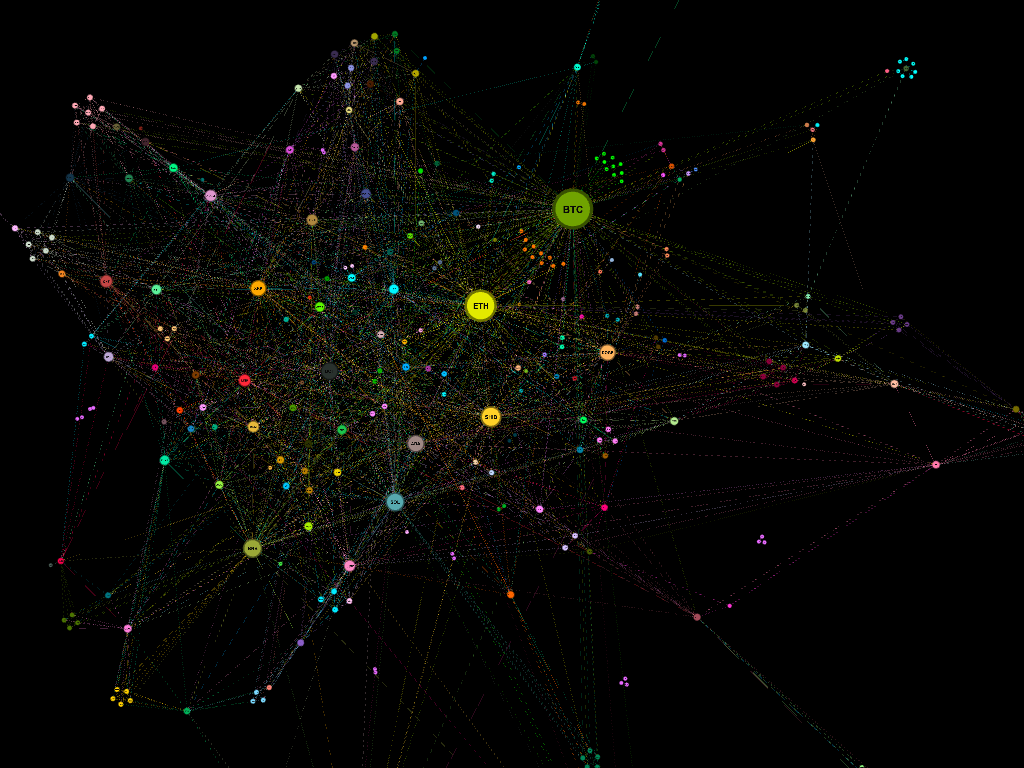</img>


<a id='3'></a>
## 3. Tear Down

Once we complete the the lab we can stop all the services

<a id='3.1'></a>
### 3.1 Stop Hadoop

Stops Hadoop
Open a terminal and execute
```sh
hadoop-stop.sh
```